# Inference 
This notebook was mainly digested from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full_Exog.ipynb. 

## 0. Utilities

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [0]:
from google.colab import files
import os
import os.path
from os import path

Please check the **real file name** after uploading.
There is no bug, but this upload solution is not perfect.

In [0]:
def upload_1_file():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    return fn

  return ""


In [0]:
def download_1_file(http_path):
  import requests
  import shutil
  response = requests.get(http_path, stream=True)

  import tempfile
  fname = tempfile.mkstemp()[1]
  
  #print(fname)
  with open(fname, 'wb') as fin:
      shutil.copyfileobj(response.raw, fin)

  return fname # Works!

In [0]:
def download_or_upload_1_file(http_or_file_path):
  if (path.exists(http_or_file_path) and (path.isfile(http_or_file_path))):
    return http_or_file_path

  if (http_or_file_path==""):
    encoder_input_file=upload_1_file()
    return encoder_input_file
  else:
    print(http_or_file_path)
    return download_1_file(http_or_file_path)

## 1. Loading Data



For convinence, I uploaded the cleaned data to the following web path.

In [0]:
encoder_input_web_or_local="https://MrYingLee.Github.io/Seq2Seq/encoder_input.npy"
decoder_target_web_or_local="https://MrYingLee.Github.io/Seq2Seq/decoder_target.npy"

### Encoder File

In [35]:
file1=download_or_upload_1_file(encoder_input_web_or_local)
encoder_input_data=np.load(file1)

https://MrYingLee.Github.io/Seq2Seq/encoder_input.npy


In [36]:
encoder_input_data.shape

(13, 489, 11)

### Decoder File

Please check the **real file name** after uploading.

In [37]:
file2=download_or_upload_1_file(decoder_target_web_or_local)
decoder_target_data=np.load(file2)

https://MrYingLee.Github.io/Seq2Seq/decoder_target.npy


In [38]:
decoder_target_data.shape

(13, 60, 1)

## 2. Loading the Model

In [0]:
from keras.models import load_model

In [0]:
model_web_or_local="https://MrYingLee.Github.io/Seq2Seq/conv_model.h5"

In [41]:
model_file=download_or_upload_1_file(model_web_or_local)
model=load_model(model_file)

https://MrYingLee.Github.io/Seq2Seq/conv_model.h5


## 3. Inference Loop

Like in the previous notebook, we'll generate predictions by running our model from section 3 in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. In each iteration we'll also update the exogenous features to include values corresponding to the next time step we'll predict. With 60 iterations, this lets us generate predictions for the full interval we've chosen. 

Recall that we designed our model to output predictions for 60 time steps at once in order to use teacher forcing for training. So if we start from a history sequence and want to predict the first future time step, we can run the model on the history sequence and take the last time step of the output, which corresponds to one time step beyond the history sequence. 

In [0]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

### 4. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder (history) /target series pairs that we didn't train on (note again we're using "encoder"/"decoder" terminology to stay consistent with notebook 1 -- here it's more like history/target). We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function which is updated to handle the addition of exogenous features in the input data, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [0]:
import matplotlib.pyplot as plt

In [0]:
pred_steps=60

def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = predict_sequence(encode_tensor)
    
    encode_series = encode_tensor[:,:(-pred_steps+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions are often strong and expressive, with similar performance to those generated by the full-fledged model without exogenous features. This suggests that the exogenous features we've added may not contribute additional predictive signal and reinforces the effectiveness of a purely endogenous model. It's possible that we haven't fully tapped into the exogenous features' potential and likely that other feature engineering techniques could help as well, but for now this would argue in favor of choosing a simpler, more efficient model over this significantly more complex one. Set out on your own to try to prove this conclusion wrong!  

One feature engineering trick that seems particularly promising is to hard-code certain long term seasonalities (i.e. quarterly or yearly) as additional features in the input sequences. I'd call this type of feature a **lagged endogenous feature** since it's derived from the actual time series. You can check out [Arthur Suilin's model description here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795) for his breakdown of this idea. I may explore this technique in a future notebook, so stay tuned!  

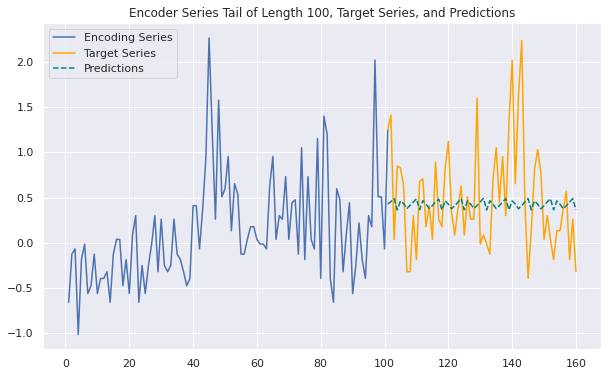

In [45]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=1, enc_tail_len=100)

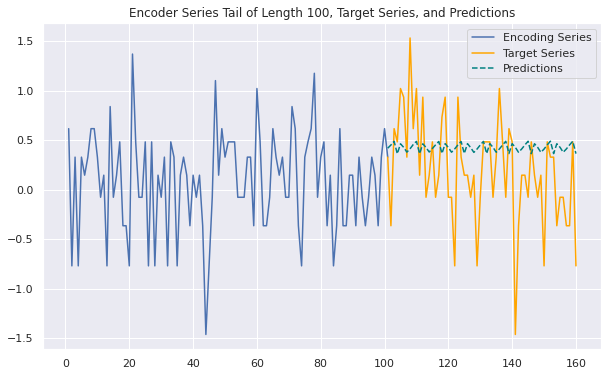

In [46]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=2, enc_tail_len=100)

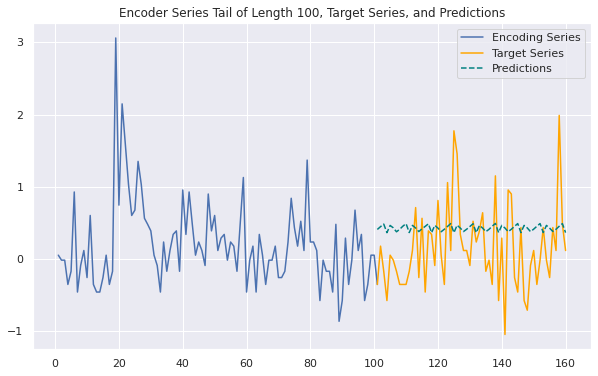

In [47]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=3, enc_tail_len=100)

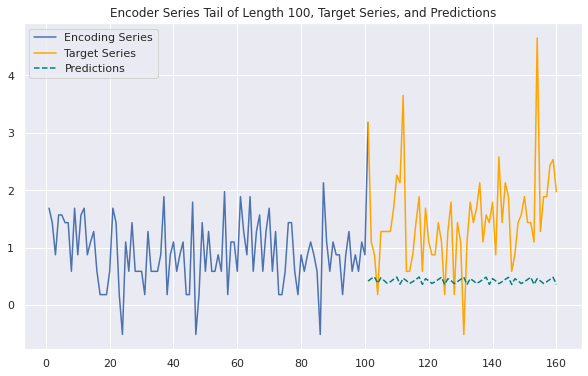

In [48]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4, enc_tail_len=100)

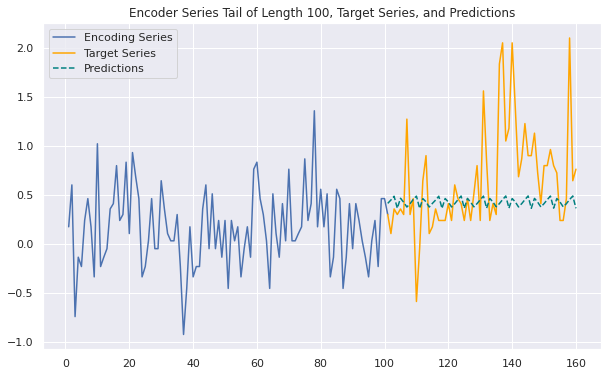

In [49]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=5, enc_tail_len=100)

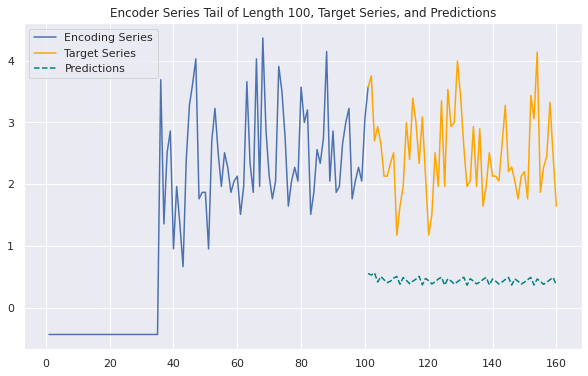

In [50]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=6, enc_tail_len=100)

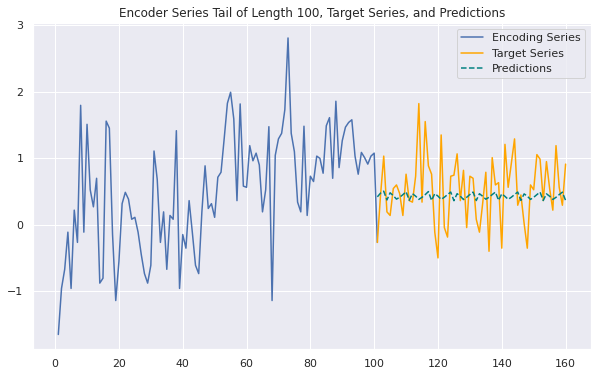

In [51]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=7, enc_tail_len=100)